# CPSC 330 - Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 
### Associated lectures: [Lectures 7, 8](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Friday, Feb 11, 2022 at 11:59pm**


## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

## Instructions 
<hr>
rubric={points:5}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2021W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

<br><br><br><br>

## Exercise 1: Implementing `DummyClassifier` 
<hr>
rubric={points:25}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: `fit` can return nothing, `predict` returns an array whose size is the number of examples, `predict_proba` returns an array whose size is the number of examples x 2, and `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [2]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """

    def fit(self, X, y):
        self.zero_cnt = len([each for each in y if each == 0]) 
        self.one_cnt = len([each for each in y if each == 1])
        return None  

    def predict(self, X):
        return np.zeros(X.shape[0]) if self.zero_cnt > self.one_cnt else np.ones(X.shape[0]) 

    def predict_proba(self, X):
        zero_proba = self.zero_cnt / (self.zero_cnt + self.one_cnt)
        one_proba = 1 - zero_proba
        return np.full((X.shape[0], 2), [zero_proba, one_proba])  

    def score(self, X, y):
        predicted = self.predict(X)
        correctly_predicted_count = len([1 for idx in range(len(y)) if predicted[idx] == y[idx]])
        return correctly_predicted_count / len(y)

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [3]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)

assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

Below are some tests for `predict_proba`.

In [4]:
assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

Below are some tests for `score`.

In [5]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

<br><br><br><br>

## Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [6]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [7]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [8]:
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [9]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
- Add a short comment to each block to describe what the code is doing.

In [10]:
# split our data into training data and testing data, with a fixed random_state so that the data will be the same even if we rerun the notebook
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

# this creates a sparse matrix for storing the bags of words for every tweet, with words such as "and", "the" and more excluded because of stop_words="english"
countvec = CountVectorizer(stop_words="english")

# create an instance of logisticRegression model with max_iteration being 1000 which is to limit the max number of iterations for the solver to converge
lr = LogisticRegression(max_iter=1000)

# create a pipeline to create bags of words and then fit it to the logistic regression model
pipe = make_pipeline(countvec, lr)

# run 5-fold (default when cv=none) cross_validation on our pipeline and return the train score
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# present the mean scores of the 5-fold validation results, including fit/score time, test/train score
cross_val_results.mean()

fit_time       1.145186
score_time     0.105332
test_score     0.898444
train_score    0.967952
dtype: float64

<br><br>

#### 2(b) Cross-validation fold sub-scores
rubric={points:5}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores. 
- Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.)
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds?

In [11]:
cross_val_results["test_score"]

0    0.895587
1    0.898047
2    0.896817
3    0.897893
4    0.903876
Name: test_score, dtype: float64

The 5 scores are close to each other (For the validation score the difference is only within +- 0.5). <br>
The size of this dataset (we have 32000+ rows of training data and 43350+ rows in the original data set before train_test split) is 100 times more larger than cities data set (which contains only 200-ish rows) we have been using in class. As the original data set is huge, even after the train_test_split and 5-fold cross validation split, our training data is still very large and will be less impacted by outliers/imbalances of data. Hence, the trian test scores tend to be more stable/less variant. However, the cities dataset only contains 200 rows, after splitting into train/test data it might be even smaller (say 150), with 5 folds cross validation, the training sample might only contain 120 rows (and 30 validation samples), it will be much easier to have imbalances across data and therefore making the variances between scores even greater.

<br><br>

#### 2(c) baseline
rubric={points:3}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset.
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
- Is it necessary to use `CountVectorizer` here? Briefly explain.

In [12]:
#taken from lecture slide
sk_dc = DummyClassifier(strategy="prior")
dummy_cross_val = pd.DataFrame(
    cross_validate(sk_dc, X_train, y_train, return_train_score=True)
)
dummy_cross_val.mean()

fit_time       0.002962
score_time     0.000580
test_score     0.735314
train_score    0.735314
dtype: float64

Yes, the mean test_score/validation_score from logistic regression is 0.898 which is way higher than that of dummyclassifier (0.735).<br>
It is not necessary to use CountVectorizer here because our dummy classifier uses "prior" strategy which only considers the y_train and count the most frequently ones. So the X_train here is not used at all and therefore we don't need to preprocess it at all.

<br><br>

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [13]:
pipe.fit(X_train, y_train);

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

In [14]:
##From lecture 7
positive_proba = pipe.predict_proba(X_test)[:, 1]
test_data_df = pd.DataFrame(X_test)
test_data_df["probi"] = positive_proba
df = pd.DataFrame(test_data_df).sort_values(by='probi', ascending=False)
print(f"the tweet with highest probability: {df.iloc[0]['content']}, its probi: {df.iloc[0]['probi']}")

the tweet with highest probability: “FBI texts have revealed anti-Trump Bias.” @ FoxNews Big News, but the Fake News doesn’t want to cover. Total corruption - the Witch Hunt has turned out to be a scam! At some point soon the Mainstream Media will have to cover correctly, too big a story!, its probi: 0.9999996937365133


The tweet with highest probability is 0.9999996937365133 and the tweet is shown above

<br><br>

#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:


In [15]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

Using these extracted components above, display the 5 words with the highest coefficients and the 5 words with the smallest coefficients.

In [16]:
coeffs = lr_from_pipe.coef_
words_coefficient_map = pd.DataFrame(data=coeffs[0], index=vec_from_pipe.get_feature_names_out(), columns=["Coefficients"])
words_coefficient_map = words_coefficient_map.sort_values("Coefficients")
print(f"5 words with highest coefficients:\n {words_coefficient_map.iloc[-1:-6:-1]}\n")
print(f"5 words with smallest coefficients:\n {words_coefficient_map.head(5)}")

5 words with highest coefficients:
              Coefficients
obamagate        2.853992
harassment       2.725251
coronavirus      2.529204
mini             2.527151
fake             2.483961

5 words with smallest coefficients:
                  Coefficients
realdonaldtrump     -3.133293
trump2016pic        -2.666677
barackobama         -2.530571
donaldtrump         -2.184534
celebapprentice     -2.106215


<br><br>

#### 2(f)
rubric={points:10}

scikit-learn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. Here, your task is to "manually" (without `Pipeline` and without `cross_validate` or `cross_val_score`) compute logistic regression's validation score on one fold (that is, train on 80% and validate on 20%) of the training data. 

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split):

In [17]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)

Meta-comment: you might be wondering why we're going into "implementation" here if this course is about _applied_ ML. In CPSC 340, we would go all the way down into `LogisticRegression` and understand how `fit` works, line by line. Here we're not going into that at all, but I still think this type of question (and Exercise 1) is a useful middle ground. I do want you to know what is going on in `Pipeline` and in `cross_validate` even if we don't cover the details of `fit`. To get into logistic regression's `fit` requires a bunch of math; here, we're keeping it more conceptual and avoiding all those prerequisites.

In [18]:
X_train_8, X_test_2, y_train_8, y_test_2 = train_test_split(X_train, y_train, random_state=111, test_size = 0.2)
X_counts_8 = countvec.fit_transform(X_train_8)
X_counts_2 = countvec.transform(X_test_2)
lr.fit(X_counts_8, y_train_8)
predicted = lr.predict(X_counts_2)
right_predicts_count = len([1 for i in range(len(predicted)) if predicted[i] == y_test_2.iloc[i]])
print(f"The validation score is {right_predicts_count / len(predicted)}")

The validation score is 0.9000461325542057


As seen above, the validation score on one fold is 0.900

<br><br><br><br>

## Exercise 3: hyperparameter optimization
<hr>

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. Based on the plot/output, what value of `max_features` seems best? Briefly explain.

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

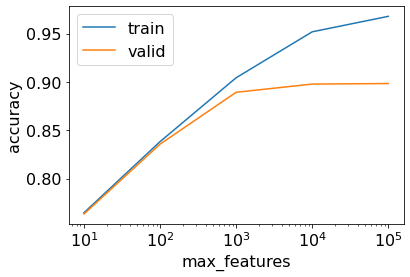

In [19]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [20]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.764701,0.763425
1,100,0.838270,0.835671
2,1000,0.904380,0.889371
3,10000,0.951936,0.897860
4,100000,0.967952,0.898444


max_features = 1000 seems best. Because first it has relatively high cross validation score and the cv score does not differ by a large extent compared with max_features = 10000 and 100000, which means that the 10/100 times increase in features might not give the equal amount of information to the model to learn better decisions/generalize better. Second, it helps reduce the time of fitting the model compared with using C = 100000.

<br><br>

#### 3(b)
rubric={points:4}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. Based on the plot, what value of `C` seems best?

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

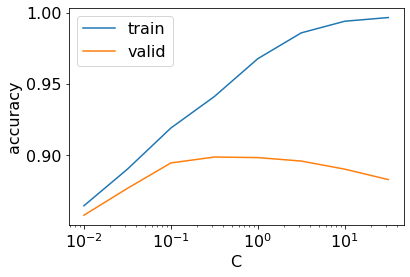

In [21]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-2, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [22]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.010000,0.864612,0.857969
1,0.031623,0.890316,0.876822
2,0.100000,0.919227,0.894692
3,0.316228,0.941333,0.898844
4,1.000000,0.967952,0.898444
5,3.162278,0.986091,0.896014
6,10.000000,0.994249,0.890324
7,31.622777,0.996840,0.883004


C = 0.316228 seems best. Because it has the highest cv score. Even though its train score is slightly higher than the cv score, the difference is still (subjectively) acceptable. However for C > 0.316, the train scores tend to be much higher than the cv score, which might imply that those C values are overfitting the training data.

<br><br>

#### 3(c)
rubric={points:12}

- Using `GridSearchCV`, jointly optimize `max_features` and `C` across all the combinations of values we tried above. 
  - Note: the code might be a bit slow here. 
  - Setting `n_jobs=-1` should speed it up if you have a multi-core processor.
  - You can reduce the number of folds (e.g. `cv=2`) to speed it up if necessary.
- What are the best values of `max_features` and `C` according to your grid search?
- Do these best values agree with what you found in parts (a) and (b)?
- Generally speaking, _should_ these values agree with what you found in parts (a) and (b)? Explain.

In [23]:
#codes adopted from lecture 8
pipe = make_pipeline(countvec, lr)
param_grid = {
    "countvectorizer__max_features": max_features,
    "logisticregression__C": C_vals,
}

grid_search = GridSearchCV(
    pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [10, 100, 1000, 10000,
                                                           100000],
                         'logisticregression__C': array([1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01])},
             return_train_score=True)

In [24]:
print(grid_search.best_score_)
grid_search.best_params_

0.8988437251093868


{'countvectorizer__max_features': 100000,
 'logisticregression__C': 0.31622776601683794}

According to my grid search the best max_features is 100000 and best C is 0.316 <br><br>
The C is exactly the same as what I found in parts (b), but the max_features is not the same, though they are still pretty close. <br><br>
Generally speaking, I think these values might not agree with what I found in parts (a) and (b) because first, for the results found in (a) and (b), we found the two param independently, however in this case, we find both params simultaneously, which could yield a different result because they might have interactions. Second, in reality we have more factors and metrics to consider. Here we only consider the cross validation score. However, if we take fit time, model complexity and other metrics into account when evaluating different sets of params, we might have a completely different result than that of GridSearchCV.

<br><br>

#### 3(d)
rubric={points:5}

- Evaluate your final model on the test set. 
- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

In [25]:
grid_search.score(X_test, y_test)

0.9018269053330873

The test accuracy is very close to our validation accuracy, which is a good sign <br>
They are different by just a small margin, so this is neither overfitting or underfitting in my opinion, it could be due to some small random noises in the datasets.

<br><br><br><br>

## Exercise 4: Very short answer questions
rubric={points:10}

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
4. What are two advantages of using sklearn `Pipeline`s? 
5. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?

1.Calling fit_transform will first fit the CountVectorizer with our test data and then transforms it. However, in no circumstance should we use our test data in training and it breaks the golden rule. Also fitting the CountVectorizer with our test data will erase previously fitted CountVectorizer which is fitted with our training data.<br><br>
2.It is important to follow the golden rule because that's the last safety net of testing our model before deployment. And we want to measure the true error of our model. If we break the golden rule and use our test data to train our model, the model accuracy may be high for the training data or test data, but once it's deployed, the result could be surprisingly bad.<br><br>
3.I would choose predict_proba because from the results of predict_proba we can always deduct the results of predict, however, we can't derive predict_proba from predict. And giving probability is clearer to us about the model's confidence in classifying things.<br><br>
4.First it helps us avoid breaking the golden rule when doing cross_validate and it ensures that our validation data will not used to fit the transformer or other models. Second, it's much easier to organize our code and make our training step cleaner in terms of readability<br><br>
5.First, the time and CPU power spent for RandomizedSearchCV is lesser as we don't have go through every single possible search space. 2. RandomizedSearchCv works better when we have some features more important than the others<br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 